# Prédiction du genre par rapport à la description du film

Ici; nous allons nous essayer de prédir le genre d'un film par rapport à sa description

Pour cela, nous utilisons le dataset fourni  IMDB_movies.csv.

Nous allons suivre les étapes suivantes :
- importer les librairies nécessaires
- charger les données
- exploration des données et pre-processing
- conversion du texte 
- construction du modèle
- création d'une fonction d'inférence

# Librairies nécessaires

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Charger les données

Chargeons d’abord les métadonnées du film qui se trouve dans le fichier IMDB_movies.csv 

In [2]:
dataset = pd.read_csv("../files/IMDB_movies.csv") 

dataset.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Bella Cola, Will Coyne, Sam Crewes, Jack Ennis, John Forde, Vera Linden, Mr. Marshall, Mr. McKenzie, Frank Mills, Ollie Wilson",True story of notorious Australian outlaw Ned Kelly (1855-80).,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helsengreen, Emil Albes, Hugo Flink, Mary Hagen","Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...",5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, Miss Robson, Helene Costello, Charles Sindelar, Mr. Howard, James R. Waite, Mr. Osborne, Harry Knowles, Mr. Paul, Mr. Brady, Mr. Corker",The fabled queen of Egypt's affair with Roman general Marc Antony is ulimately disastrous for both of them.,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de Liguoro, Pier Delle Vigne, Augusto Milla, Attilio Motta, Emilise Beretta",Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Nazareth","From the Manger to the Cross; or, Jesus of Nazareth",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier, Alice Hollister, Samuel Morgan, James D. Ainsley, Robert G. Vignola, George Kellog, J.P. McGowan","An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


Maintenant, nous allons créer un autre ensemble de données avec l'id du poster et sa description. C'est ce qui nous intéresse ici.

In [3]:
movie_id=[]
description=[]
length = len(dataset)

for i in range(0,length):
    movie_id.append(dataset.loc[i]["imdb_title_id"])
    description.append(dataset.loc[i]["description"])
    
movies = pd.DataFrame({'imdb_title_id': movie_id, 'description': description})

movies.head()

,imdb_title_id,description
0,tt0000574,True story of notorious Australian outlaw Ned Kelly (1855-80).
1,tt0001892,"Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ..."
2,tt0002101,The fabled queen of Egypt's affair with Roman general Marc Antony is ulimately disastrous for both of them.
3,tt0002130,Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.
4,tt0002199,"An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise..."


# Exploration des données et Pre-processing

Nous allons ajouter les noms des films et leurs genres à partir du dataset en fusionnant ce dernier avec movies basé sur la colonne imdb_title_id.

In [4]:
# merge dataset with movies
movies = pd.merge(movies, dataset[['imdb_title_id', 'title', 'genre']], on = 'imdb_title_id')

movies.head()

,imdb_title_id,description,title,genre
0,tt0000574,True story of notorious Australian outlaw Ned Kelly (1855-80).,The Story of the Kelly Gang,"Biography, Crime, Drama"
1,tt0001892,"Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...",Den sorte drøm,Drama
2,tt0002101,The fabled queen of Egypt's affair with Roman general Marc Antony is ulimately disastrous for both of them.,Cleopatra,"Drama, History"
3,tt0002130,Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,L'Inferno,"Adventure, Drama, Fantasy"
4,tt0002199,"An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise...","From the Manger to the Cross; or, Jesus of Nazareth","Biography, Drama"


Ensuite, nous avons ajouté les noms et les genres des films. 
Cependant, les genres sont du type string. Il sera plus facile de travailler avec une liste. 
C'est pourquoi nous allons créer une nouvelle colonne genre_new de type liste contenant les genres du film.

In [5]:
type((movies['genre'][0]))

str

In [6]:
genres = []

for i in movies['genre']:
    genres.append(i.split(r", "))


movies['genre_new'] = genres

Certains échantillons pourraient ne contenir aucune étiquette de genre. Par conséquent, nous devrions retirer ces échantillons car ils n’aideront pas beaucoup dans la construction de modèles.

In [7]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [8]:
movies_new.shape, movies.shape

((81273, 5), (81273, 5))

On constate qu'il n'y a pas d'échantillons ne contenant aucune étiquette de genre. 
Vérifions encore une fois le dataframe.

In [9]:
movies_new.head()

,imdb_title_id,description,title,genre,genre_new
0,tt0000574,True story of notorious Australian outlaw Ned Kelly (1855-80).,The Story of the Kelly Gang,"Biography, Crime, Drama","[Biography, Crime, Drama]"
1,tt0001892,"Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...",Den sorte drøm,Drama,[Drama]
2,tt0002101,The fabled queen of Egypt's affair with Roman general Marc Antony is ulimately disastrous for both of them.,Cleopatra,"Drama, History","[Drama, History]"
3,tt0002130,Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,L'Inferno,"Adventure, Drama, Fantasy","[Adventure, Drama, Fantasy]"
4,tt0002199,"An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise...","From the Manger to the Cross; or, Jesus of Nazareth","Biography, Drama","[Biography, Drama]"


Les genres sont maintenant dans le format de liste qui va être utile puisque nous devrons accéder à ces balises de genre plus tard.

Pour savoir le nombre de genres de films qu'il y a dans ce jeu de données, on utilise le code suivant :

In [51]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

26

Il y a 26 balises de genre uniques dans notre ensemble de données.

Voyons de plus près ce que sont ces étiquettes. Nous utiliserons FreqDist( ) de la bibliothèque nltk pour créer un dictionnaire des genres et leur nombre d’occurences dans l’ensemble de données.

In [11]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

Nous allons visualiser l'ensemble des données.

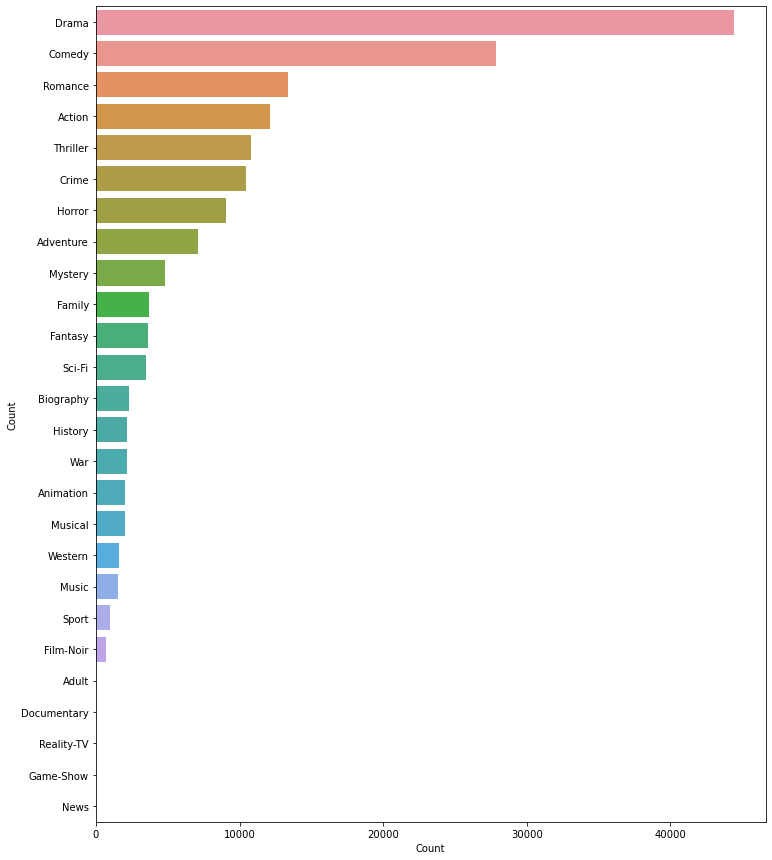

In [12]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

Comme prévu, les tags les plus fréquents sont "Drama", "Comedy", "Romance", "Action", et "Thriller". Le reste des genres dans les données proviennent d’une façon ou d’une autre des cinq principaux genres.

Ainsi, maintenant nous pouvons décider si nous voulons travailler avec un certain nombre de genres les plus fréquents ou tous les genres. Ici, nous allons considérer tous les genres (soit 26).

Ensuite, nous allons nettoyer les descriptions des films. Je vais utiliser quelques étapes de nettoyage de texte très simples car ce n’est pas le domaine d’intérêt de cet article.

In [13]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text

Appliquons cette fonction sur les descriptions des films.

In [14]:
length_movies = len(movies_new)
clean_desc =[]

for i in range(0,length):
    txt = str(movies_new.loc[i]["description"])
    clean_desc.append(clean_text(txt))

movies_new["clean_desc"]=clean_desc

Ici, nous allons vérifier quelques échantillons aléatoires.

In [52]:
movies_new[['description', 'clean_desc']].sample(3)

,description,clean_desc
80548,"A man makes a decision that alters generations, and must suffer great consequences that reach beyond this lifetime.",man makes decision alters generations must suffer great consequences reach beyond lifetime
28313,"Police Inspector Jay Bakshi has been assigned the task of aprpehending gangsters affiliated to notorious criminal don, Raj Solanki. Assisting him in this task is his sweetheart, Inspector ...",police inspector jay bakshi assigned task aprpehending gangsters affiliated notorious criminal raj solanki assisting task sweetheart inspector
21579,"The German professor tries out his time machine in Turkey. Everybody is after this new invention - Superman Detective Murat, his cheating colleagues Atak and Matrak as well as the mob ...",german professor tries time machine turkey everybody new invention superman detective murat cheating colleagues atak matrak well mob


On constate que dans la colonne clean_desc, il n'y a pas de signe de ponctuation et le texte est en minuscule. Ainsi, notre nettoyage de texte a bien fonctionné. 

La fonction ci-contre permet de visualiser les mots avec leurs fréquences. Nous allons l'utiliser pour découvire les mots les plus fréquents dans les intrigues de film.

In [68]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

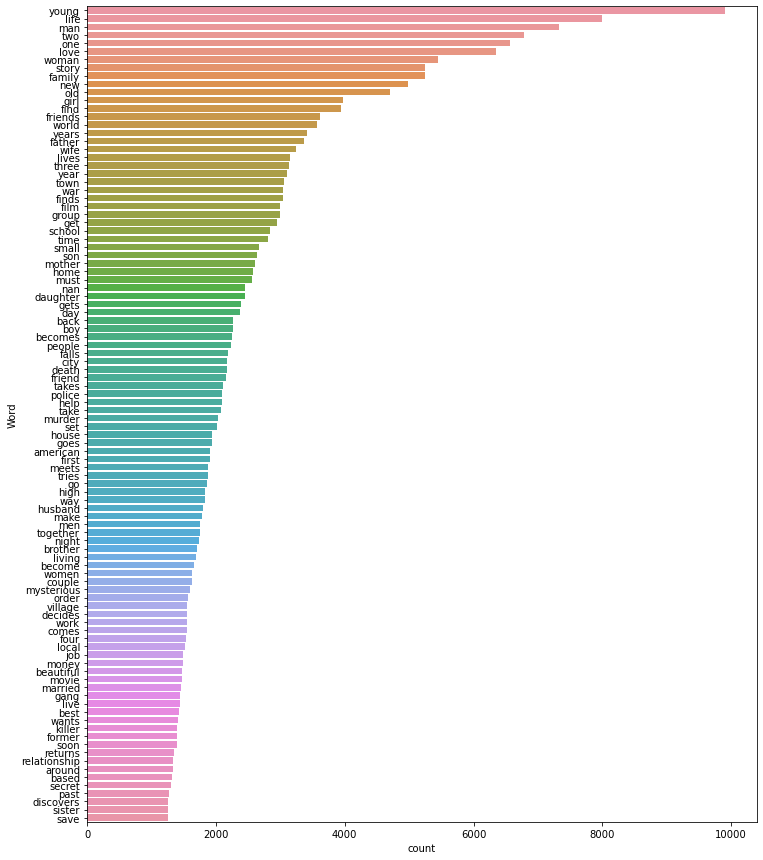

In [69]:
# print 100 most frequent words
freq_words(movies_new['clean_desc'], 100)

Nous constatons que la plupart des termes de l'intrigue sont des stopwords. Ces stopwords ont une signification moins importante que d'autres mot-clés dans le texte. Du coup, nous allons les supprimer du texte. Pour cela, il faut dans un premier temps télécharger la liste des stopwords à partir de la bibliothèque nltk.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/lyne/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Maintenant, nous allons supprimer tous les stopwords.

In [22]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
movies_new['clean_desc'] = movies_new['clean_desc'].apply(lambda x: remove_stopwords(x))

Nous allons vérifier les mots les plus fréquents après la suppression des stopwords

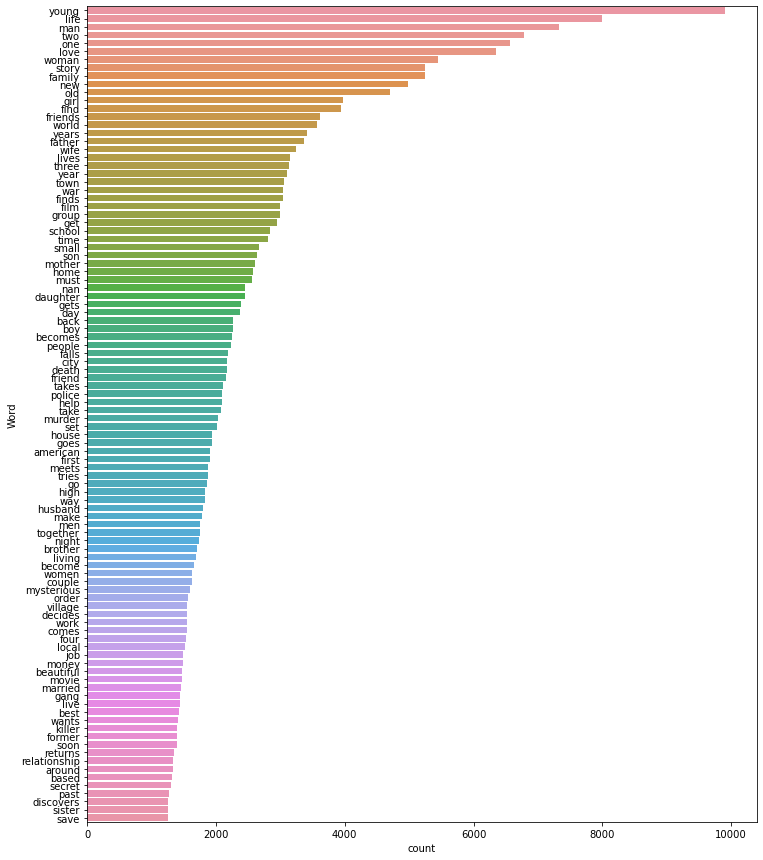

In [23]:
freq_words(movies_new['clean_desc'], 100)

Il s’avère que les mots les plus intéressants sont "young", "life", "man" et bien d’autres.

# Conversion du texte en fonction


Nous allons traiter ce problème de classification multilabel comme un problème de pertinence binaire. Par consqéuent, nous allons maintenant encoder la variable cible, genre_new en utilisant le MultiLabelBinarizer() de sklearn. Puisqu'il y a 26 balises de genre uniques, il va y avoir 26 nouvelles variables cibles.

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

Nous avons réussi à transformer la variable cible et maintenant nous concentrer sur l'extraction de caractéristiques à partir de la version nettoyée des descriptions de films. Nous avons décidé d'utiliser les caractéristiques TF-IDF. 
Il existe d'autre méthodes d'extraction comme Bag-of-Words, word2vec, GloVe, or ELMo.

In [53]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

Nous avons utilisé les 10 000 mots les plus fréquents dans les données comme caractéristiques. Vous pouvez essayer tout autre nombre pour le paramètre max_features. 

Avant de créer les caractéristiques TF-IDF, nous allons diviser nos données en ensembles d'entrainement et de validation pour la formation et l'évaluation des performances, respectivement. 

80% des échantillons de données ont été conservés dans l'ensemble d'entrainement et le reste des données est dans l'ensemble de validation.

In [27]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_desc'], y, test_size=0.2, random_state=9)

Maintenant, nous pouvons créer des fonctionnalités pour l'ensemble d'entrainement et de validation.

In [28]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Construction du modèle de prédiction

Nous utilisons donc l'approche de la pertinence binaire pour résoudre un problème multilabel, ainsi nous devons encoder la variable cible et ensuite contruire un modèle pour chaque variable cible. Puisque nous avons 26 variables cibles, nous devrons adapter 26 modèles différents avec le même ensemble de prédicteurs (caractéristique de la TF-IDF).

In [29]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

Nous allons utiliser la classe OneVsRestClassifier pour résoudre ce problème.

In [30]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Enfin, nous allons adapter notre modèle sur l'ensemble d'entrainement.

In [31]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/Users/lyne/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lyne/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

OneVsRestClassifier(estimator=LogisticRegression())

Une fois que notre modèle est formé, nous pouvons prédire les genres de films pour l’ensemble de validation. 

Faisons-le.

In [32]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

Vérifions une prédiction.

In [33]:
y_pred[3]

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

C’est un tableau binaire unidimensionnel de longueur 26. Fondamentalement, c’est la forme encodée. 
Ainsi, nous devons utiliser la fonction inverse_transform() avec l’objet MultiLabelBinarizer() de la bibliothèque sklearn pour convertir le tableau prédit en étiquettes de genre de film. .

In [47]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Comedy', 'Drama')

Nous allons évaluer la performance de notre modèle pour cela nous devons tenir compte de toutes les prévisions et la variable cible de l'ensemble de validation.

In [35]:
 # evaluate performance
f1_score(yval, y_pred, average="micro")

0.4910070900063752

Nous obtenons un score F1 décent de 0,491. Ces prédictions ont été faites sur la base d'une valeur seuil de 0,5, ce qui signifie que les probabilités supérieures ou égales à 0,5 ont été converties en 1 et les autres en 0. Essayons de modifier cette valeur seuil et voyons si cela aide notre modèle.

In [36]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

Maintenant, définissez une autre valeur seuil.

In [66]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

Nous avons essayé 0,3 comme valeur seuil. Nous pouvons également essayer toute autre valeur. Vérifions à nouveau le score F1 sur ces nouvelles prédictions

In [67]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5753197044773461

Les performances s'en trouvent considérablement améliorées. Une meilleure approche pour trouver la bonne valeur de seuil serait d'utiliser une configuration de validation croisée k-fold et d'essayer différentes valeurs de seuil.

# Création d'une fonction d'inférence


Maintenant que nous avons entraîné notre modèle et que nous avons également fait des prédictions pour l'ensemble de validation. Cependant, nous devons également prendre en compte les nouvelles données ou les nouvelles séquences de films qui arriveront dans le futur. 

Notre système de prédiction de genre de film doit être capable de prendre une intrigue de film sous forme brute en entrée et fournir ses étiquettes de genre en sortie.

Pour cela, nous allons construire une fonction d'inférence. <br>
Elle prendra en entrée une descritpion de film et suivra les étapes suivantes :
- Nettoyer le texte 
- Supprimer les stopwords
- Extraire les caractéristiques du texte 
- Faire des prédictions
- Retouurne les étiquettes de genre de film prédites

In [39]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

Testons cette fonction d’inférence sur quelques échantillons de l’ensemble de validation.

In [50]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("Movie: ", movies_new['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k],"\n")

Movie:  Not with My Wife, You Don't! 
Predicted genre:  [('Drama', 'Romance')]
Actual genre:  ['Comedy'] 

Movie:  Bienvenido a casa 
Predicted genre:  [('Drama',)]
Actual genre:  ['Comedy', 'Drama', 'Romance'] 

Movie:  Fallen 
Predicted genre:  [('Comedy', 'Drama')]
Actual genre:  ['Drama'] 

Movie:  Stolen Hours 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 

Movie:  Adventures of Rusty 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama', 'Family'] 

